In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [10]:
file_name = "/content/gdrive/MyDrive/Colab Notebooks/Yakutsk_weather_19102020_01102012.csv"

In [13]:
df = pd.read_csv(file_name, sep=';',encoding='iso-8859-1')
df.head(10)

,LocalTime,T,P0,P,U,DD
0,19.10.2020 17:00,-7.0,745.9,758.2,68.0,Âåòåð
1,19.10.2020 16:30,-6.0,746.0,758.2,63.0,Âåòåð
2,19.10.2020 16:00,-5.0,746.0,758.2,58.0,Âåòåð
3,19.10.2020 15:30,-4.0,746.1,758.2,59.0,Âåòåð
4,19.10.2020 15:00,-4.0,746.1,758.2,54.0,Âåòåð
5,19.10.2020 14:30,-4.0,746.1,758.2,63.0,Âåòåð
6,19.10.2020 14:00,-4.0,746.1,758.2,63.0,Âåòåð
7,19.10.2020 13:30,-4.0,746.1,758.2,63.0,Âåòåð
8,19.10.2020 13:00,-3.0,746.1,758.2,64.0,Âåòåð
9,19.10.2020 12:30,-4.0,746.1,758.2,63.0,Âåòåð


In [14]:
df.drop('DD', axis=1, inplace=True)
df.head(10)

,LocalTime,T,P0,P,U
0,19.10.2020 17:00,-7.0,745.9,758.2,68.0
1,19.10.2020 16:30,-6.0,746.0,758.2,63.0
2,19.10.2020 16:00,-5.0,746.0,758.2,58.0
3,19.10.2020 15:30,-4.0,746.1,758.2,59.0
4,19.10.2020 15:00,-4.0,746.1,758.2,54.0
5,19.10.2020 14:30,-4.0,746.1,758.2,63.0
6,19.10.2020 14:00,-4.0,746.1,758.2,63.0
7,19.10.2020 13:30,-4.0,746.1,758.2,63.0
8,19.10.2020 13:00,-3.0,746.1,758.2,64.0
9,19.10.2020 12:30,-4.0,746.1,758.2,63.0


In [15]:
df.describe()

,T,P0,P,U
count,116050.000000,116049.000000,116049.000000,116048.000000
mean,-8.092632,748.080996,760.517001,66.698022
std,21.679891,6.743260,7.464018,17.645702
min,-50.000000,726.800000,738.100000,8.000000
25%,-29.000000,743.400000,755.400000,57.000000
50%,-4.000000,747.700000,759.700000,68.000000
75%,11.000000,752.400000,765.000000,78.000000
max,35.000000,773.400000,787.700000,100.000000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116051 entries, 0 to 116050
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   LocalTime  116051 non-null  object 
 1   T          116050 non-null  float64
 2   P0         116049 non-null  float64
 3   P          116049 non-null  float64
 4   U          116048 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.4+ MB


array([[<Axes: title={'center': 'T'}>, <Axes: title={'center': 'P0'}>],
       [<Axes: title={'center': 'P'}>, <Axes: title={'center': 'U'}>]],
      dtype=object)

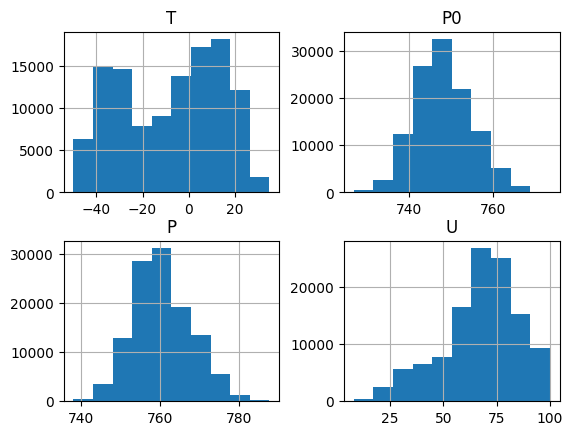

In [17]:
df.hist()

In [18]:
df = df[['LocalTime','T']]
df.head()

,LocalTime,T
0,19.10.2020 17:00,-7.0
1,19.10.2020 16:30,-6.0
2,19.10.2020 16:00,-5.0
3,19.10.2020 15:30,-4.0
4,19.10.2020 15:00,-4.0


In [19]:
df.isna().sum()

LocalTime    0
T            1
dtype: int64

In [20]:
df.dropna(inplace=True)

In [21]:
df.isna().sum()

LocalTime    0
T            0
dtype: int64

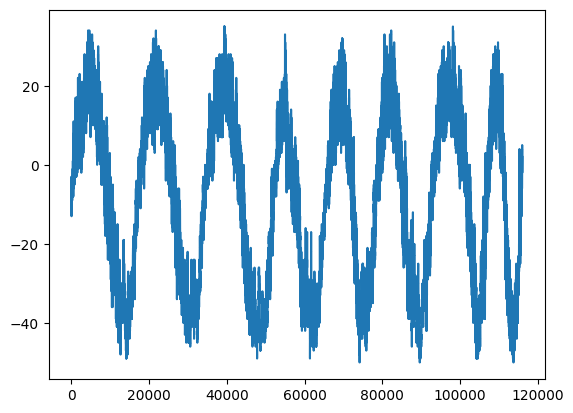

In [22]:
plt.plot(range(1,len(df['T'].values)+1),df['T'].values)

In [23]:
# Extract and normalize the target column
min_max_scaler = MinMaxScaler()
df = df['T'].values
df = min_max_scaler.fit_transform(df.reshape(-1, 1))

In [24]:
df.shape

(116050, 1)

In [25]:
# Flatten the data shape
df = df.flatten()
df.shape

(116050,)

## Split data to train, test, and validation

In [26]:
window = 15

# Calculate the number of samples for training, validation, and test sets
n_samples = df.shape[0] - window
n_train_samples = round(0.7 * n_samples)
n_val_samples = round(0.15 * n_samples)
n_test_samples = n_samples - n_train_samples - n_val_samples

print('Train = ',n_train_samples,'Validation = ',n_val_samples,'Test = ',n_test_samples)

Train =  81224 Validation =  17405 Test =  17406


In [27]:
# Function to create input-output pairs for a given set
def create_pairs(start_index, num_samples):
    X = [df[start_index + i : start_index + i + window] for i in range(num_samples)]
    y = [df[start_index + i + window] for i in range(num_samples)]
    return np.array(X), np.array(y)

In [28]:
# Create training, validation, and test sets
X_train, y_train = create_pairs(0, n_train_samples)
X_val, y_val = create_pairs(n_train_samples, n_val_samples)
X_test, y_test = create_pairs(n_train_samples + n_val_samples, n_test_samples)

In [29]:
# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Regressor (RNN)

In [30]:
# Build the RNN model
rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(10, activation='sigmoid', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')
])

In [31]:
# Compile the RNN model
rnn_model.compile(loss='mse',
                  optimizer='adam',
                  metrics='mae')

In [32]:
# Train the RNN model
rnn_history = rnn_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=20,
    validation_data=(X_val, y_val)
)

Epoch 1/10
4062/4062 [==============================] - 15s 3ms/step - loss: 0.0359 - mae: 0.1334 - val_loss: 0.0069 - val_mae: 0.0662
Epoch 2/10
4062/4062 [==============================] - 12s 3ms/step - loss: 0.0103 - mae: 0.0798 - val_loss: 0.0027 - val_mae: 0.0406
Epoch 3/10
4062/4062 [==============================] - 12s 3ms/step - loss: 0.0062 - mae: 0.0616 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 4/10
4062/4062 [==============================] - 13s 3ms/step - loss: 0.0049 - mae: 0.0539 - val_loss: 0.0011 - val_mae: 0.0274
Epoch 5/10
4062/4062 [==============================] - 12s 3ms/step - loss: 0.0045 - mae: 0.0511 - val_loss: 7.1738e-04 - val_mae: 0.0217
Epoch 6/10
4062/4062 [==============================] - 13s 3ms/step - loss: 0.0042 - mae: 0.0497 - val_loss: 7.1133e-04 - val_mae: 0.0215
Epoch 7/10
4062/4062 [==============================] - 12s 3ms/step - loss: 0.0041 - mae: 0.0490 - val_loss: 5.6993e-04 - val_mae: 0.0193
Epoch 8/10
4062/4062 [=====================

## MSE, MAE R2

In [33]:
# Get R2, MSE, & MAE scores
y_pred = rnn_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

544/544 [==============================] - 1s 2ms/step
MSE: 0.00
MAE: 0.02
R-squared (R^2): 0.99


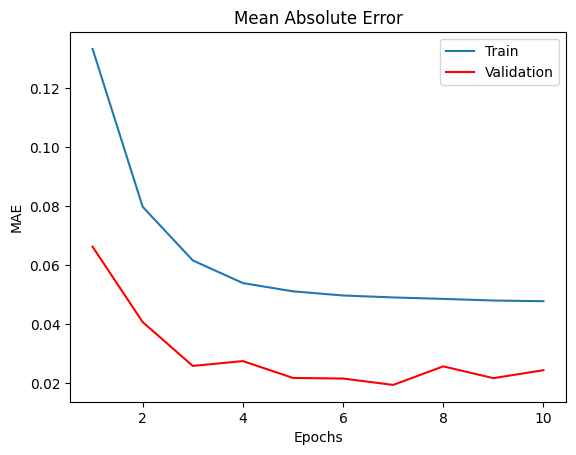

In [34]:
# Visualize the mean absolute error
mae = rnn_history.history['mae']
val_mae = rnn_history.history['val_mae']
epochs = range(1,len(mae)+1)

plt.title('Mean Absolute Error')
plt.plot(epochs,mae,label='Train')
plt.plot(epochs,val_mae,color='red',label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Predict

In [37]:
# Predict using test sets
y_pred = rnn_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

544/544 [==============================] - 2s 3ms/step
MAE =  2.083  degrees
R2-score =  0.985


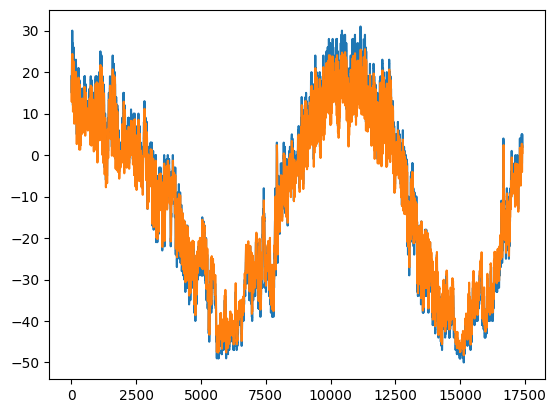

In [38]:
# Visualize prediction
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)

# Регрессор (LSTM)

In [39]:
# Build the LSTM model
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(10, activation='sigmoid', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    tf.keras.layers.Dense(1, activation='relu')
])

In [40]:
# Compile the LSTM model
lstm_model.compile(loss='mse',
                  optimizer='adam',
                  metrics='mae')

In [41]:
# Train the LSTM model
lstm_history = lstm_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=20,
    validation_data=(X_val, y_val)
)

Epoch 1/10
4062/4062 [==============================] - 16s 4ms/step - loss: 0.0166 - mae: 0.0965 - val_loss: 0.0038 - val_mae: 0.0498
Epoch 2/10
4062/4062 [==============================] - 13s 3ms/step - loss: 0.0073 - mae: 0.0665 - val_loss: 0.0017 - val_mae: 0.0321
Epoch 3/10
4062/4062 [==============================] - 14s 3ms/step - loss: 0.0051 - mae: 0.0552 - val_loss: 9.8784e-04 - val_mae: 0.0245
Epoch 4/10
4062/4062 [==============================] - 13s 3ms/step - loss: 0.0044 - mae: 0.0506 - val_loss: 8.9978e-04 - val_mae: 0.0237
Epoch 5/10
4062/4062 [==============================] - 14s 3ms/step - loss: 0.0041 - mae: 0.0487 - val_loss: 0.0011 - val_mae: 0.0268
Epoch 6/10
4062/4062 [==============================] - 15s 4ms/step - loss: 0.0040 - mae: 0.0474 - val_loss: 6.4596e-04 - val_mae: 0.0201
Epoch 7/10
4062/4062 [==============================] - 14s 3ms/step - loss: 0.0039 - mae: 0.0471 - val_loss: 7.2043e-04 - val_mae: 0.0215
Epoch 8/10
4062/4062 [=================

## MSE, MAE, R2

In [42]:
# Get R2, MSE, & MAE scores
y_pred = lstm_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

544/544 [==============================] - 1s 2ms/step
MSE: 0.00
MAE: 0.02
R-squared (R^2): 0.99


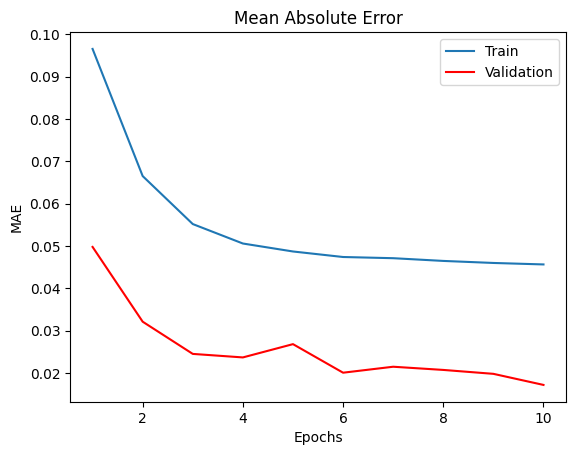

In [43]:
# Visualize the mean absolute error
mae = lstm_history.history['mae']
val_mae = lstm_history.history['val_mae']
epochs = range(1,len(mae)+1)

plt.title('Mean Absolute Error')
plt.plot(epochs,mae,label='Train')
plt.plot(epochs,val_mae,color='red',label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Predict

In [44]:
# Predict using test sets
y_pred = lstm_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

544/544 [==============================] - 1s 2ms/step
MAE =  1.727  degrees
R2-score =  0.989


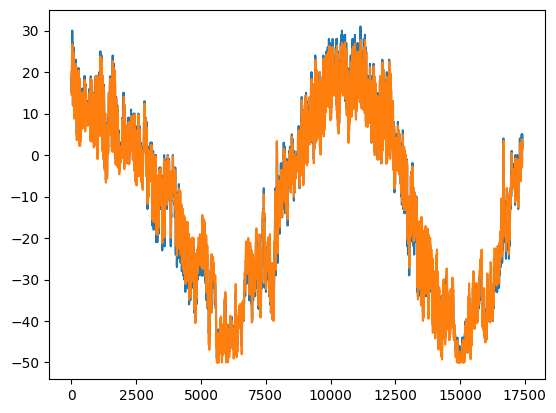

In [45]:
# Visualize prediction
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)

# Regressor (LSTM 2 Layers)

In [46]:
# Build the LSTM model
lstm_model2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(10, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True),
    Dropout(0.2),
    tf.keras.layers.LSTM(10, activation='sigmoid'),
    Dropout(0.2),
    tf.keras.layers.Dense(1, activation='relu')
])

In [47]:
# Compile the LSTM model
lstm_model2.compile(loss='mse',
                  optimizer='adam',
                  metrics='mae')

In [48]:
# Train the LSTM model
lstm_history2 = lstm_model2.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=20,
    validation_data=(X_val, y_val)
)

Epoch 1/20
4062/4062 [==============================] - 23s 5ms/step - loss: 0.0353 - mae: 0.1334 - val_loss: 0.0053 - val_mae: 0.0556
Epoch 2/20
4062/4062 [==============================] - 20s 5ms/step - loss: 0.0096 - mae: 0.0741 - val_loss: 0.0028 - val_mae: 0.0382
Epoch 3/20
4062/4062 [==============================] - 20s 5ms/step - loss: 0.0086 - mae: 0.0694 - val_loss: 0.0027 - val_mae: 0.0378
Epoch 4/20
4062/4062 [==============================] - 20s 5ms/step - loss: 0.0080 - mae: 0.0666 - val_loss: 0.0024 - val_mae: 0.0361
Epoch 5/20
4062/4062 [==============================] - 20s 5ms/step - loss: 0.0077 - mae: 0.0652 - val_loss: 0.0023 - val_mae: 0.0347
Epoch 6/20
4062/4062 [==============================] - 19s 5ms/step - loss: 0.0073 - mae: 0.0633 - val_loss: 0.0020 - val_mae: 0.0337
Epoch 7/20
4062/4062 [==============================] - 20s 5ms/step - loss: 0.0073 - mae: 0.0622 - val_loss: 0.0029 - val_mae: 0.0414
Epoch 8/20
4062/4062 [==============================] -

## MSE, MAE, R2

In [49]:
# Get R2, MSE, & MAE scores
y_pred = lstm_model2.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

544/544 [==============================] - 1s 2ms/step
MSE: 0.00
MAE: 0.04
R-squared (R^2): 0.96


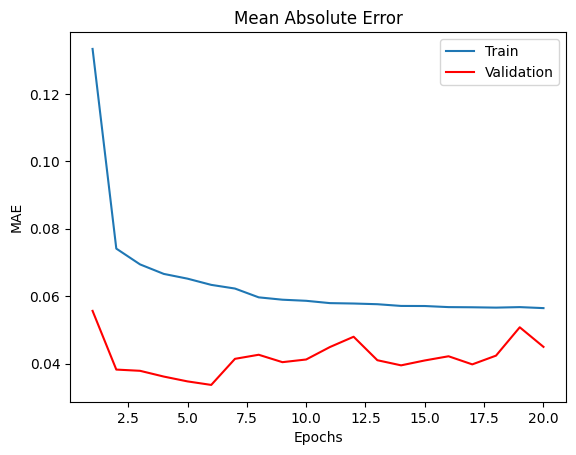

In [50]:
# Visualize the mean absolute error
mae = lstm_history2.history['mae']
val_mae = lstm_history2.history['val_mae']
epochs = range(1,len(mae)+1)

plt.title('Mean Absolute Error')
plt.plot(epochs,mae,label='Train')
plt.plot(epochs,val_mae,color='red',label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Predict

In [51]:
# Predict using test sets
y_pred = lstm_model2.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

544/544 [==============================] - 1s 2ms/step
MAE =  3.323  degrees
R2-score =  0.962


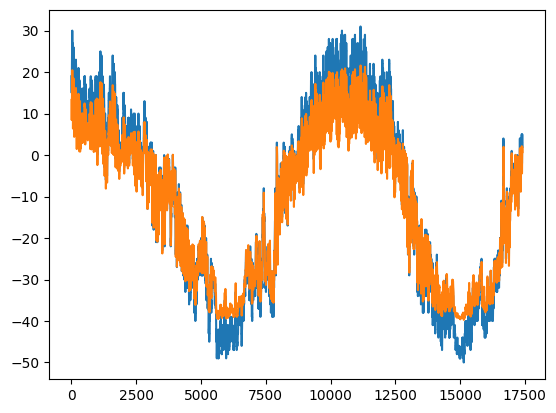

In [52]:
# Visualize prediction
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)